## Setting

In [1]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 102.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.9 MB/s eta 0:00:00


In [2]:
import os
import json
import numpy 
import matplotlib.pyplot as plt

In [3]:
import argparse
import glob
import logging
import os
import random
import timeit

import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

import transformers
from transformers import (
    MODEL_FOR_QUESTION_ANSWERING_MAPPING,
    WEIGHTS_NAME,
    AdamW,
    AutoConfig,
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    squad_convert_examples_to_features,
)
from transformers.data.metrics.squad_metrics import (
    compute_predictions_log_probs,
    compute_predictions_logits,
    squad_evaluate,
)
from transformers.data.processors.squad import SquadResult, SquadV1Processor, SquadV2Processor
from transformers.trainer_utils import is_main_process


In [4]:
from transformers import ElectraModel, ElectraTokenizer

model = ElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator")
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Data Preprocessing

### 1. 원본 데이터 탐색
- 데이터 다운로드
  - KorQuAD 1.0 데이터 (https://korquad.github.io/KorQuad%201.0/) 에서 Training set, Dev set 다운로드 후 Google Drive에 업로드
- 데이터 구성
  - 1,560 개의 Wikipedia article에 대해 10,645 건의 문단과 66,181 개의 질의응답 쌍
  - Training set 60,407 개, Dev set 5,774 개의 질의응답쌍

In [5]:
DATAPATH = "/content/drive/MyDrive/인공지능/질의응답/data/korquad"  
filenames = [x for x in os.listdir (DATAPATH) if x.endswith('json')]
filenames.sort()
filenames

['KorQuAD_v1.0_dev.json', 'KorQuAD_v1.0_train.json']

In [6]:
file = filenames[1]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

In [7]:
data[0]

{'paragraphs': [{'qas': [{'answers': [{'text': '교향곡', 'answer_start': 54}],
     'id': '6566495-0-0',
     'question': '바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?'},
    {'answers': [{'text': '1악장', 'answer_start': 421}],
     'id': '6566495-0-1',
     'question': '바그너는 교향곡 작곡을 어디까지 쓴 뒤에 중단했는가?'},
    {'answers': [{'text': '베토벤의 교향곡 9번', 'answer_start': 194}],
     'id': '6566495-0-2',
     'question': '바그너가 파우스트 서곡을 쓸 때 어떤 곡의 영향을 받았는가?'},
    {'answers': [{'text': '파우스트', 'answer_start': 15}],
     'id': '6566518-0-0',
     'question': '1839년 바그너가 교향곡의 소재로 쓰려고 했던 책은?'},
    {'answers': [{'text': '합창교향곡', 'answer_start': 354}],
     'id': '6566518-0-1',
     'question': '파우스트 서곡의 라단조 조성이 영향을 받은 베토벤의 곡은?'},
    {'answers': [{'text': '1839', 'answer_start': 0}],
     'id': '5917067-0-0',
     'question': '바그너가 파우스트를 처음으로 읽은 년도는?'},
    {'answers': [{'text': '파리', 'answer_start': 410}],
     'id': '5917067-0-1',
     'question': '바그너가 처음 교향곡 작곡을 한 장소는?'},
    {'answers': [{'text': '드레스덴', 'answer_sta

## EDA

### Train

In [8]:
file = filenames[1]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

In [9]:
cont_lens = []
q_lens = []
a_lens = []

para_num = 0
cont_num = 0
q_num = 0

cont_unk_num = 0
q_unk_num = 0
a_unk_num = 0

for x in range(len(data)):
  paragraphs = data[x]['paragraphs']
  para_num += 1

  # context
  for para in paragraphs:
    context = para['context']
    cont_num += 1
    con_tokens = tokenizer.tokenize(context)
    cont_lens.append(len(con_tokens))

    for t in con_tokens:
      if t == ['UNK']:
        cont_unk_num += 1

    # qas
    qas = para['qas']
    for qa in qas:
      question = qa['question']
      answer = qa['answers'][0]['text']
      q_num += 1
      q_tokens  = tokenizer.tokenize(question)
      a_tokens = tokenizer.tokenize(answer)
      q_lens.append(len(q_tokens))
      a_lens.append(len(a_tokens))

      for t in q_tokens:
        if t == '[UNK]':
          q_unk_num += 1
      
      for t in a_tokens:
        if t == '[UNK]':
          a_unk_num += 1

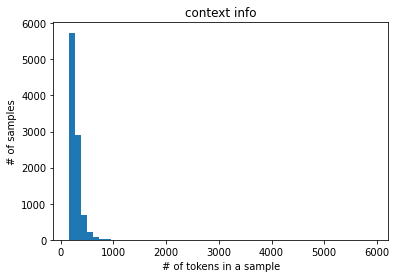

-------------------------context info-----------------------------
# of paragraphs = 1420 | # of contexts = 9681
min = 147 | mean = 274.51 | median = 245.00 | max = 5925
# of [UNK] tokens = 0 | % of [UNK] tokens = 0.00%


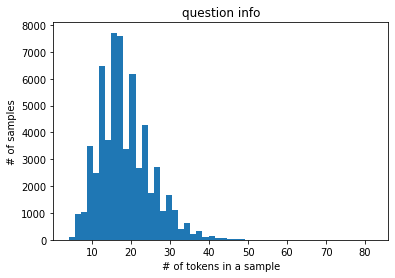

--------------- question info ---------------
# of questions = 60407
min = 4 | mean = 18.46 | median = 18.00 | max = 82
# of [UNK] tokens = 110 | % of [UNK] tokens = 0.01%


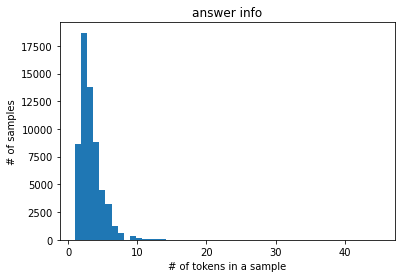

--------------- answer info ---------------
# of answers = 60407
min = 1 | mean = 3.12 | median = 3.00 | max = 45
# of [UNK] tokens = 109 | % of [UNK] tokens = 0.06%


In [10]:
# context
min = numpy.min(cont_lens)
mean = numpy.mean(cont_lens)
median = numpy.median(cont_lens)
max = numpy.max(cont_lens)

plt.hist(cont_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('context info')
plt.show()

print('-------------------------context info-----------------------------')
print('# of paragraphs = {} | # of contexts = {}'.format(para_num, cont_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(cont_unk_num, 100*(cont_unk_num/sum(cont_lens))))

#question
min = numpy.min(q_lens)
mean = numpy.mean(q_lens)
median = numpy.median(q_lens)
max = numpy.max(q_lens)

plt.hist(q_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('question info')
plt.show()

print('--------------- question info ---------------')
print('# of questions = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(q_unk_num, 100*(q_unk_num/sum(q_lens))))

#answer
min = numpy.min(a_lens)
mean = numpy.mean(a_lens)
median = numpy.median(a_lens)
max = numpy.max(a_lens)

plt.hist(a_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('answer info')
plt.show()

print('--------------- answer info ---------------')
print('# of answers = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(a_unk_num, 100*(a_unk_num/sum(a_lens))))

### Dev

In [11]:
file = filenames[0]
filelocation = os.path.join(DATAPATH, file)

with open(filelocation, 'r') as json_file:
  data = json.load(json_file)['data']

In [12]:
cont_lens = []
q_lens = []
a_lens = []

para_num = 0
cont_num = 0
q_num = 0

cont_unk_num = 0
q_unk_num = 0
a_unk_num = 0

for x in range(len(data)):
  paragraphs = data[x]['paragraphs']
  para_num += 1

  # context
  for para in paragraphs:
    context = para['context']
    cont_num += 1
    con_tokens = tokenizer.tokenize(context)
    cont_lens.append(len(con_tokens))

    for t in con_tokens:
      if t == ['UNK']:
        cont_unk_num += 1

    # qas
    qas = para['qas']
    for qa in qas:
      question = qa['question']
      answer = qa['answers'][0]['text']
      q_num += 1
      q_tokens  = tokenizer.tokenize(question)
      a_tokens = tokenizer.tokenize(answer)
      q_lens.append(len(q_tokens))
      a_lens.append(len(a_tokens))

      for t in q_tokens:
        if t == '[UNK]':
          q_unk_num += 1
      
      for t in a_tokens:
        if t == '[UNK]':
          a_unk_num += 1

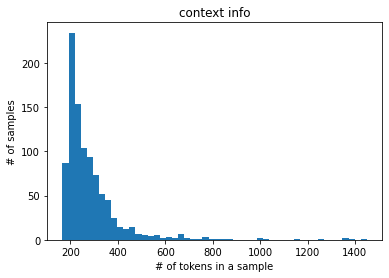

-------------------------context info-----------------------------
# of paragraphs = 140 | # of contexts = 964
min = 166 | mean = 284.69 | median = 244.50 | max = 1450
# of [UNK] tokens = 0 | % of [UNK] tokens = 0.00%


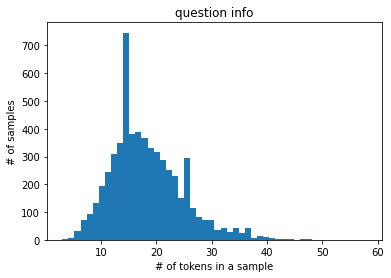

--------------- question info ---------------
# of questions = 5774
min = 3 | mean = 18.19 | median = 17.00 | max = 58
# of [UNK] tokens = 9 | % of [UNK] tokens = 0.01%


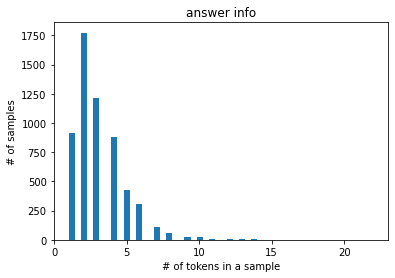

--------------- answer info ---------------
# of answers = 5774
min = 1 | mean = 3.08 | median = 3.00 | max = 22
# of [UNK] tokens = 10 | % of [UNK] tokens = 0.06%


In [13]:
# context
min = numpy.min(cont_lens)
mean = numpy.mean(cont_lens)
median = numpy.median(cont_lens)
max = numpy.max(cont_lens)

plt.hist(cont_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('context info')
plt.show()

print('-------------------------context info-----------------------------')
print('# of paragraphs = {} | # of contexts = {}'.format(para_num, cont_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(cont_unk_num, 100*(cont_unk_num/sum(cont_lens))))

#question
min = numpy.min(q_lens)
mean = numpy.mean(q_lens)
median = numpy.median(q_lens)
max = numpy.max(q_lens)

plt.hist(q_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('question info')
plt.show()

print('--------------- question info ---------------')
print('# of questions = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(q_unk_num, 100*(q_unk_num/sum(q_lens))))

#answer
min = numpy.min(a_lens)
mean = numpy.mean(a_lens)
median = numpy.median(a_lens)
max = numpy.max(a_lens)

plt.hist(a_lens, bins=50)
plt.xlabel('# of tokens in a sample')
plt.ylabel('# of samples')
plt.title('answer info')
plt.show()

print('--------------- answer info ---------------')
print('# of answers = {}'.format(q_num))
print('min = {} | mean = {:.2f} | median = {:.2f} | max = {}'.format(min, mean, median, max))
print('# of [UNK] tokens = {} | % of [UNK] tokens = {:.2f}%'.format(a_unk_num, 100*(a_unk_num/sum(a_lens))))

### 3. Feature 생성

In [14]:
# def load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=False):
#     if args.local_rank not in [-1, 0] and not evaluate:
#         # Make sure only the first process in distributed training process the dataset, and the others will use the cache
#         torch.distributed.barrier()

#     # Load data features from cache or dataset file
#     input_dir = args.data_dir if args.data_dir else "."
#     cached_features_file = os.path.join(
#         input_dir,
#         "cached_{}_{}_{}".format(
#             "dev" if evaluate else "train",
#             list(filter(None, args.model_name_or_path.split("/"))).pop(),
#             str(args.max_seq_length),
#         ),
#     )

#     # Init features and dataset from cache if it exists
#     if os.path.exists(cached_features_file) and not args.overwrite_cache:
#         logger.info("Loading features from cached file %s", cached_features_file)
#         features_and_dataset = torch.load(cached_features_file)
#         features, dataset, examples = (
#             features_and_dataset["features"],
#             features_and_dataset["dataset"],
#             features_and_dataset["examples"],
#         )
#     else:
#         logger.info("Creating features from dataset file at %s", input_dir)

#         if not args.data_dir and ((evaluate and not args.predict_file) or (not evaluate and not args.train_file)):
#             try:
#                 import tensorflow_datasets as tfds
#             except ImportError:
#                 raise ImportError("If not data_dir is specified, tensorflow_datasets needs to be installed.")

#             if args.version_2_with_negative:
#                 logger.warning("tensorflow_datasets does not handle version 2 of SQuAD.")

#             tfds_examples = tfds.load("squad")
#             examples = SquadV1Processor().get_examples_from_dataset(tfds_examples, evaluate=evaluate)
#         else:
#             processor = SquadV2Processor() if args.version_2_with_negative else SquadV1Processor()
#             if evaluate:
#                 examples = processor.get_dev_examples(args.data_dir, filename=args.predict_file)
#             else:
#                 examples = processor.get_train_examples(args.data_dir, filename=args.train_file)

#         features, dataset = squad_convert_examples_to_features(
#             examples=examples,
#             tokenizer=tokenizer,
#             max_seq_length=args.max_seq_length,
#             doc_stride=args.doc_stride,
#             max_query_length=args.max_query_length,
#             is_training=not evaluate,
#             return_dataset="pt",
#             threads=args.threads,
#         )

#         if args.local_rank in [-1, 0]:
#             logger.info("Saving features into cached file %s", cached_features_file)
#             torch.save({"features": features, "dataset": dataset, "examples": examples}, cached_features_file)

#     if args.local_rank == 0 and not evaluate:
#         # Make sure only the first process in distributed training process the dataset, and the others will use the cache
#         torch.distributed.barrier()

#     if output_examples:
#         return dataset, examples, features
#     return dataset

## Training
- 하이퍼파라미터 설정
  - model_type
    - transformers의 MODEL_FOR_QUESTION_ANSWERING_MAPPING 목록에 있는 모델 종류 중 선택
    - 'albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'bloom', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'flaubert', 'fnet', 'funnel', 'gptj', 'ibert', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'longformer', 'mbart', 'megatron-bert', 'mobilebert', 'reformer', 'rembert', 'roberta', 'roformer', 'splinter', 'squeezebert', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'yoso’ 등
  - model_name_or_path
    - 사전 학습 모델 경로 혹은 huggingface.co/models에 업로드 된 model idenfitier
  - output_dir
    - 모델의 checkpoint 및 prediction 파일 저장 경로
  - data_dir
    - 데이터셋 경로. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - train_file
    - 학습 파일. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - predict_file
    - 평가 파일. 설정을 하지 않으면 tensorflow_datasets을 통해 실행
  - config_name
    - model_name과 동일하지 않을 시 설정하는 config 이름 혹은 경로
  - tokenizer_name
    - model_name과 동일하지 않을 시 설정하는 tokenizer 이름 혹은 경로
  - cache_dir
    - huggingface.co에서 다운로드한 사전 학습 모델 저장 경로
  - version_2_with_negative
    - no-answer 포함하는 데이터셋일 경우 true로 설정
  - null_score_diff_threshold
    - null_score - best_non_null이 prediction null의 threshold보다 큰 경우
  - max_seq_length
    - WordPiece로 토크나이징 후 input sequence의 길이. max_seq_length보다 길면 truncate, 짧으면 padding
  - doc_stride
    - 긴 문서를 chunk로 분할할 때 chunk 사이에 겹치는 토큰 수 (stride)
  - max_query_length
    - 질문 토큰의 최대 길이. max_query_length보다 길면 truncate
  - do_train
    - 학습 여부
  - do_eval
    - 평가 여부
  - evaluate_during_training
    - 학습 시 logging step마다 평가 여부
  - do_lower_case
    - uncased 모델일 경우 설정. 한국어 모델은 uncased 모델
  - per_gpu_train_batch_size
    - 학습 시 batch size
  - per_gpu_eval_batch_size
    - 평가 시 batch size
  - learning_rate
    - Adam optimizer의 초기 learning rate
gradient_accumulation_steps
    - backward/update pass 시 쌓을 steps 수
batch size가 커서 OOM 에러가 발생할 때, mini-batch를 통해 구해진 gradient를 global gradient에 누적시킨 후 한번에 update
    - 예: batch_size = 16, gradient_accumulation_steps = 16 이면 batch _size = 256의 효과이나 학습 시간이 매우 길어짐
  - weight_decay
    - overfitting을 막기 위한 weight decay
  - adam_epsilon
    - Adam optimizer의 epsilon 값
  - max_grad_norm
    - grandient clipping을 위한 max gradient norm
  - num_train_epochs
    - 학습 epoch 수
  - max_steps
    - 학습 step 수. 0보다 크면 num_train_epochs을 상속받음.
  - warmup_steps
    - linear warmup 을 위한 step 수
  - n_best_size
    - nbest_prediction.json 파일을 통해 생성되는 n-best prediction의 개수
  - max_answer_length
    - 생성할 수 있는 최대 정답의 길이
  - verbose_logging
    - true로 설정 시 데이터 전처리 시 발생하는 warning 모두 출력
  - lang_id
    - language-specific xlm 모델을 위한 값. (ELECTRA와는 상관 없음)
  - logging_steps
    - n step 마다 로그 작성
  - save_steps
    - n step 마다 checkpoint 저장
  - eval_all_checkpoints
    - 모든 checkpoint 평가 여부
  - no_cuda
    - true로 설정 시 GPU 사용하지 않음
  - overwrite_output_dir
    - output 디렉토리 overwrite 여부
  - overwrite_cache
    - cache 파일 overwrite 여부
  - seed
    - 초기화를 위한 random seed
  - local_rank
    - GPU 분산 학습을 위한 local rank
  - fp16
    - NVIDIA apex를 통해 계산량을 줄이기 위한 목적으로 single(fp32)와 half(fp16)를 섞은 mixed precision 사용 여부
    - master weigth를 fp32에서 fp16로 변환한 후 back/forward propagatio은 fp16로 연산 수행. 이후 weight update 시 다시 fp32
  - fp16_opt_level
    - Apex AMP optimization
  - server_ip
    - distant debugging을 위해 사용
  - server_port
    - distant debugging을 위해 사용
  - threads
    - example에서 feature 생성할 때 사용할 multiple threads

In [15]:
# # coding=utf-8
# # Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# # Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
# #
# # Licensed under the Apache License, Version 2.0 (the "License");
# # you may not use this file except in compliance with the License.
# # You may obtain a copy of the License at
# #
# #     http://www.apache.org/licenses/LICENSE-2.0
# #
# # Unless required by applicable law or agreed to in writing, software
# # distributed under the License is distributed on an "AS IS" BASIS,
# # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# # See the License for the specific language governing permissions and
# # limitations under the License.
# """ Finetuning the library models for question-answering on SQuAD (DistilBERT, Bert, XLM, XLNet)."""


# import argparse
# import glob
# import logging
# import os
# import random
# import timeit

# import numpy as np
# import torch
# from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# from torch.utils.data.distributed import DistributedSampler
# from tqdm import tqdm, trange

# import transformers
# from transformers import (
#     MODEL_FOR_QUESTION_ANSWERING_MAPPING,
#     WEIGHTS_NAME,
#     AdamW,
#     AutoConfig,
#     AutoModelForQuestionAnswering,
#     AutoTokenizer,
#     get_linear_schedule_with_warmup,
#     squad_convert_examples_to_features,
# )
# from transformers.data.metrics.squad_metrics import (
#     compute_predictions_log_probs,
#     compute_predictions_logits,
#     squad_evaluate,
# )
# from transformers.data.processors.squad import SquadResult, SquadV1Processor, SquadV2Processor
# from transformers.trainer_utils import is_main_process


# try:
#     from torch.utils.tensorboard import SummaryWriter
# except ImportError:
#     from tensorboardX import SummaryWriter


# logger = logging.getLogger(__name__)

# MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
# MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)


# def set_seed(args):
#     random.seed(args.seed)
#     np.random.seed(args.seed)
#     torch.manual_seed(args.seed)
#     if args.n_gpu > 0:
#         torch.cuda.manual_seed_all(args.seed)


# def to_list(tensor):
#     return tensor.detach().cpu().tolist()


# def train(args, train_dataset, model, tokenizer):
#     """Train the model"""
#     if args.local_rank in [-1, 0]:
#         tb_writer = SummaryWriter()

#     args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
#     train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
#     train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)

#     if args.max_steps > 0:
#         t_total = args.max_steps
#         args.num_train_epochs = args.max_steps // (len(train_dataloader) // args.gradient_accumulation_steps) + 1
#     else:
#         t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

#     # Prepare optimizer and schedule (linear warmup and decay)
#     no_decay = ["bias", "LayerNorm.weight"]
#     optimizer_grouped_parameters = [
#         {
#             "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
#             "weight_decay": args.weight_decay,
#         },
#         {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
#     ]
#     optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
#     scheduler = get_linear_schedule_with_warmup(
#         optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
#     )

#     # Check if saved optimizer or scheduler states exist
#     if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
#         os.path.join(args.model_name_or_path, "scheduler.pt")
#     ):
#         # Load in optimizer and scheduler states
#         optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
#         scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

#     if args.fp16:
#         try:
#             from apex import amp
#         except ImportError:
#             raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")

#         model, optimizer = amp.initialize(model, optimizer, opt_level=args.fp16_opt_level)

#     # multi-gpu training (should be after apex fp16 initialization)
#     if args.n_gpu > 1:
#         model = torch.nn.DataParallel(model)

#     # Distributed training (should be after apex fp16 initialization)
#     if args.local_rank != -1:
#         model = torch.nn.parallel.DistributedDataParallel(
#             model, device_ids=[args.local_rank], output_device=args.local_rank, find_unused_parameters=True
#         )

#     # Train!
#     logger.info("***** Running training *****")
#     logger.info("  Num examples = %d", len(train_dataset))
#     logger.info("  Num Epochs = %d", args.num_train_epochs)
#     logger.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
#     logger.info(
#         "  Total train batch size (w. parallel, distributed & accumulation) = %d",
#         args.train_batch_size
#         * args.gradient_accumulation_steps
#         * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
#     )
#     logger.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
#     logger.info("  Total optimization steps = %d", t_total)

#     global_step = 1
#     epochs_trained = 0
#     steps_trained_in_current_epoch = 0
#     # Check if continuing training from a checkpoint
#     if os.path.exists(args.model_name_or_path):
#         try:
#             # set global_step to gobal_step of last saved checkpoint from model path
#             checkpoint_suffix = args.model_name_or_path.split("-")[-1].split("/")[0]
#             global_step = int(checkpoint_suffix)
#             epochs_trained = global_step // (len(train_dataloader) // args.gradient_accumulation_steps)
#             steps_trained_in_current_epoch = global_step % (len(train_dataloader) // args.gradient_accumulation_steps)

#             logger.info("  Continuing training from checkpoint, will skip to saved global_step")
#             logger.info("  Continuing training from epoch %d", epochs_trained)
#             logger.info("  Continuing training from global step %d", global_step)
#             logger.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)
#         except ValueError:
#             logger.info("  Starting fine-tuning.")

#     tr_loss, logging_loss = 0.0, 0.0
#     model.zero_grad()
#     train_iterator = trange(
#         epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0]
#     )
#     # Added here for reproductibility
#     set_seed(args)

#     for _ in train_iterator:
#         epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0])
#         for step, batch in enumerate(epoch_iterator):

#             # Skip past any already trained steps if resuming training
#             if steps_trained_in_current_epoch > 0:
#                 steps_trained_in_current_epoch -= 1
#                 continue

#             model.train()
#             batch = tuple(t.to(args.device) for t in batch)

#             inputs = {
#                 "input_ids": batch[0],
#                 "attention_mask": batch[1],
#                 "token_type_ids": batch[2],
#                 "start_positions": batch[3],
#                 "end_positions": batch[4],
#             }

#             if args.model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
#                 del inputs["token_type_ids"]

#             if args.model_type in ["xlnet", "xlm"]:
#                 inputs.update({"cls_index": batch[5], "p_mask": batch[6]})
#                 if args.version_2_with_negative:
#                     inputs.update({"is_impossible": batch[7]})
#                 if hasattr(model, "config") and hasattr(model.config, "lang2id"):
#                     inputs.update(
#                         {"langs": (torch.ones(batch[0].shape, dtype=torch.int64) * args.lang_id).to(args.device)}
#                     )

#             outputs = model(**inputs)
#             # model outputs are always tuple in transformers (see doc)
#             loss = outputs[0]

#             if args.n_gpu > 1:
#                 loss = loss.mean()  # mean() to average on multi-gpu parallel (not distributed) training
#             if args.gradient_accumulation_steps > 1:
#                 loss = loss / args.gradient_accumulation_steps

#             if args.fp16:
#                 with amp.scale_loss(loss, optimizer) as scaled_loss:
#                     scaled_loss.backward()
#             else:
#                 loss.backward()

#             tr_loss += loss.item()
#             if (step + 1) % args.gradient_accumulation_steps == 0:
#                 if args.fp16:
#                     torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), args.max_grad_norm)
#                 else:
#                     torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

#                 optimizer.step()
#                 scheduler.step()  # Update learning rate schedule
#                 model.zero_grad()
#                 global_step += 1

#                 # Log metrics
#                 if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
#                     # Only evaluate when single GPU otherwise metrics may not average well
#                     if args.local_rank == -1 and args.evaluate_during_training:
#                         results = evaluate(args, model, tokenizer)
#                         for key, value in results.items():
#                             tb_writer.add_scalar("eval_{}".format(key), value, global_step)
#                     tb_writer.add_scalar("lr", scheduler.get_lr()[0], global_step)
#                     tb_writer.add_scalar("loss", (tr_loss - logging_loss) / args.logging_steps, global_step)
#                     logging_loss = tr_loss

#                 # Save model checkpoint
#                 if args.local_rank in [-1, 0] and args.save_steps > 0 and global_step % args.save_steps == 0:
#                     output_dir = os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
#                     # Take care of distributed/parallel training
#                     model_to_save = model.module if hasattr(model, "module") else model
#                     model_to_save.save_pretrained(output_dir)
#                     tokenizer.save_pretrained(output_dir)

#                     torch.save(args, os.path.join(output_dir, "training_args.bin"))
#                     logger.info("Saving model checkpoint to %s", output_dir)

#                     torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
#                     torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
#                     logger.info("Saving optimizer and scheduler states to %s", output_dir)

#             if args.max_steps > 0 and global_step > args.max_steps:
#                 epoch_iterator.close()
#                 break
#         if args.max_steps > 0 and global_step > args.max_steps:
#             train_iterator.close()
#             break

#     if args.local_rank in [-1, 0]:
#         tb_writer.close()

#     return global_step, tr_loss / global_step


# def evaluate(args, model, tokenizer, prefix=""):
#     dataset, examples, features = load_and_cache_examples(args, tokenizer, evaluate=True, output_examples=True)

#     if not os.path.exists(args.output_dir) and args.local_rank in [-1, 0]:
#         os.makedirs(args.output_dir)

#     args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)

#     # Note that DistributedSampler samples randomly
#     eval_sampler = SequentialSampler(dataset)
#     eval_dataloader = DataLoader(dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

#     # multi-gpu evaluate
#     if args.n_gpu > 1 and not isinstance(model, torch.nn.DataParallel):
#         model = torch.nn.DataParallel(model)

#     # Eval!
#     logger.info("***** Running evaluation {} *****".format(prefix))
#     logger.info("  Num examples = %d", len(dataset))
#     logger.info("  Batch size = %d", args.eval_batch_size)

#     all_results = []
#     start_time = timeit.default_timer()

#     for batch in tqdm(eval_dataloader, desc="Evaluating"):
#         model.eval()
#         batch = tuple(t.to(args.device) for t in batch)

#         with torch.no_grad():
#             inputs = {
#                 "input_ids": batch[0],
#                 "attention_mask": batch[1],
#                 "token_type_ids": batch[2],
#             }

#             if args.model_type in ["xlm", "roberta", "distilbert", "camembert", "bart", "longformer"]:
#                 del inputs["token_type_ids"]

#             feature_indices = batch[3]

#             # XLNet and XLM use more arguments for their predictions
#             if args.model_type in ["xlnet", "xlm"]:
#                 inputs.update({"cls_index": batch[4], "p_mask": batch[5]})
#                 # for lang_id-sensitive xlm models
#                 if hasattr(model, "config") and hasattr(model.config, "lang2id"):
#                     inputs.update(
#                         {"langs": (torch.ones(batch[0].shape, dtype=torch.int64) * args.lang_id).to(args.device)}
#                     )
#             outputs = model(**inputs)

#         for i, feature_index in enumerate(feature_indices):
#             eval_feature = features[feature_index.item()]
#             unique_id = int(eval_feature.unique_id)

#             output = [to_list(output[i]) for output in outputs.to_tuple()]

#             # Some models (XLNet, XLM) use 5 arguments for their predictions, while the other "simpler"
#             # models only use two.
#             if len(output) >= 5:
#                 start_logits = output[0]
#                 start_top_index = output[1]
#                 end_logits = output[2]
#                 end_top_index = output[3]
#                 cls_logits = output[4]

#                 result = SquadResult(
#                     unique_id,
#                     start_logits,
#                     end_logits,
#                     start_top_index=start_top_index,
#                     end_top_index=end_top_index,
#                     cls_logits=cls_logits,
#                 )

#             else:
#                 start_logits, end_logits = output
#                 result = SquadResult(unique_id, start_logits, end_logits)

#             all_results.append(result)

#     evalTime = timeit.default_timer() - start_time
#     logger.info("  Evaluation done in total %f secs (%f sec per example)", evalTime, evalTime / len(dataset))

#     # Compute predictions
#     output_prediction_file = os.path.join(args.output_dir, "predictions_{}.json".format(prefix))
#     output_nbest_file = os.path.join(args.output_dir, "nbest_predictions_{}.json".format(prefix))

#     if args.version_2_with_negative:
#         output_null_log_odds_file = os.path.join(args.output_dir, "null_odds_{}.json".format(prefix))
#     else:
#         output_null_log_odds_file = None

#     # XLNet and XLM use a more complex post-processing procedure
#     if args.model_type in ["xlnet", "xlm"]:
#         start_n_top = model.config.start_n_top if hasattr(model, "config") else model.module.config.start_n_top
#         end_n_top = model.config.end_n_top if hasattr(model, "config") else model.module.config.end_n_top

#         predictions = compute_predictions_log_probs(
#             examples,
#             features,
#             all_results,
#             args.n_best_size,
#             args.max_answer_length,
#             output_prediction_file,
#             output_nbest_file,
#             output_null_log_odds_file,
#             start_n_top,
#             end_n_top,
#             args.version_2_with_negative,
#             tokenizer,
#             args.verbose_logging,
#         )
#     else:
#         predictions = compute_predictions_logits(
#             examples,
#             features,
#             all_results,
#             args.n_best_size,
#             args.max_answer_length,
#             args.do_lower_case,
#             output_prediction_file,
#             output_nbest_file,
#             output_null_log_odds_file,
#             args.verbose_logging,
#             args.version_2_with_negative,
#             args.null_score_diff_threshold,
#             tokenizer,
#         )

#     # Compute the F1 and exact scores.
#     results = squad_evaluate(examples, predictions)
#     return results


# def load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=False):
#     if args.local_rank not in [-1, 0] and not evaluate:
#         # Make sure only the first process in distributed training process the dataset, and the others will use the cache
#         torch.distributed.barrier()

#     # Load data features from cache or dataset file
#     input_dir = args.data_dir if args.data_dir else "."
#     cached_features_file = os.path.join(
#         input_dir,
#         "cached_{}_{}_{}".format(
#             "dev" if evaluate else "train",
#             list(filter(None, args.model_name_or_path.split("/"))).pop(),
#             str(args.max_seq_length),
#         ),
#     )

#     # Init features and dataset from cache if it exists
#     if os.path.exists(cached_features_file) and not args.overwrite_cache:
#         logger.info("Loading features from cached file %s", cached_features_file)
#         features_and_dataset = torch.load(cached_features_file)
#         features, dataset, examples = (
#             features_and_dataset["features"],
#             features_and_dataset["dataset"],
#             features_and_dataset["examples"],
#         )
#     else:
#         logger.info("Creating features from dataset file at %s", input_dir)

#         if not args.data_dir and ((evaluate and not args.predict_file) or (not evaluate and not args.train_file)):
#             try:
#                 import tensorflow_datasets as tfds
#             except ImportError:
#                 raise ImportError("If not data_dir is specified, tensorflow_datasets needs to be installed.")

#             if args.version_2_with_negative:
#                 logger.warning("tensorflow_datasets does not handle version 2 of SQuAD.")

#             tfds_examples = tfds.load("squad")
#             examples = SquadV1Processor().get_examples_from_dataset(tfds_examples, evaluate=evaluate)
#         else:
#             processor = SquadV2Processor() if args.version_2_with_negative else SquadV1Processor()
#             if evaluate:
#                 examples = processor.get_dev_examples(args.data_dir, filename=args.predict_file)
#             else:
#                 examples = processor.get_train_examples(args.data_dir, filename=args.train_file)

#         features, dataset = squad_convert_examples_to_features(
#             examples=examples,
#             tokenizer=tokenizer,
#             max_seq_length=args.max_seq_length,
#             doc_stride=args.doc_stride,
#             max_query_length=args.max_query_length,
#             is_training=not evaluate,
#             return_dataset="pt",
#             threads=args.threads,
#         )

#         if args.local_rank in [-1, 0]:
#             logger.info("Saving features into cached file %s", cached_features_file)
#             torch.save({"features": features, "dataset": dataset, "examples": examples}, cached_features_file)

#     if args.local_rank == 0 and not evaluate:
#         # Make sure only the first process in distributed training process the dataset, and the others will use the cache
#         torch.distributed.barrier()

#     if output_examples:
#         return dataset, examples, features
#     return dataset


# def main():
#     parser = argparse.ArgumentParser()

#     # Required parameters
#     parser.add_argument(
#         "--model_type",
#         default=None,
#         type=str,
#         required=True,
#         help="Model type selected in the list: " + ", ".join(MODEL_TYPES),
#     )
#     parser.add_argument(
#         "--model_name_or_path",
#         default=None,
#         type=str,
#         required=True,
#         help="Path to pretrained model or model identifier from huggingface.co/models",
#     )
#     parser.add_argument(
#         "--output_dir",
#         default=None,
#         type=str,
#         required=True,
#         help="The output directory where the model checkpoints and predictions will be written.",
#     )

#     # Other parameters
#     parser.add_argument(
#         "--data_dir",
#         default=None,
#         type=str,
#         help="The input data dir. Should contain the .json files for the task."
#         + "If no data dir or train/predict files are specified, will run with tensorflow_datasets.",
#     )
#     parser.add_argument(
#         "--train_file",
#         default=None,
#         type=str,
#         help="The input training file. If a data dir is specified, will look for the file there"
#         + "If no data dir or train/predict files are specified, will run with tensorflow_datasets.",
#     )
#     parser.add_argument(
#         "--predict_file",
#         default=None,
#         type=str,
#         help="The input evaluation file. If a data dir is specified, will look for the file there"
#         + "If no data dir or train/predict files are specified, will run with tensorflow_datasets.",
#     )
#     parser.add_argument(
#         "--config_name", default="", type=str, help="Pretrained config name or path if not the same as model_name"
#     )
#     parser.add_argument(
#         "--tokenizer_name",
#         default="",
#         type=str,
#         help="Pretrained tokenizer name or path if not the same as model_name",
#     )
#     parser.add_argument(
#         "--cache_dir",
#         default="",
#         type=str,
#         help="Where do you want to store the pre-trained models downloaded from huggingface.co",
#     )

#     parser.add_argument(
#         "--version_2_with_negative",
#         action="store_true",
#         help="If true, the SQuAD examples contain some that do not have an answer.",
#     )
#     parser.add_argument(
#         "--null_score_diff_threshold",
#         type=float,
#         default=0.0,
#         help="If null_score - best_non_null is greater than the threshold predict null.",
#     )

#     parser.add_argument(
#         "--max_seq_length",
#         default=384,
#         type=int,
#         help=(
#             "The maximum total input sequence length after WordPiece tokenization. Sequences "
#             "longer than this will be truncated, and sequences shorter than this will be padded."
#         ),
#     )
#     parser.add_argument(
#         "--doc_stride",
#         default=128,
#         type=int,
#         help="When splitting up a long document into chunks, how much stride to take between chunks.",
#     )
#     parser.add_argument(
#         "--max_query_length",
#         default=64,
#         type=int,
#         help=(
#             "The maximum number of tokens for the question. Questions longer than this will "
#             "be truncated to this length."
#         ),
#     )
#     parser.add_argument("--do_train", action="store_true", help="Whether to run training.")
#     parser.add_argument("--do_eval", action="store_true", help="Whether to run eval on the dev set.")
#     parser.add_argument(
#         "--evaluate_during_training", action="store_true", help="Run evaluation during training at each logging step."
#     )
#     parser.add_argument(
#         "--do_lower_case", action="store_true", help="Set this flag if you are using an uncased model."
#     )

#     parser.add_argument("--per_gpu_train_batch_size", default=8, type=int, help="Batch size per GPU/CPU for training.")
#     parser.add_argument(
#         "--per_gpu_eval_batch_size", default=8, type=int, help="Batch size per GPU/CPU for evaluation."
#     )
#     parser.add_argument("--learning_rate", default=5e-5, type=float, help="The initial learning rate for Adam.")
#     parser.add_argument(
#         "--gradient_accumulation_steps",
#         type=int,
#         default=1,
#         help="Number of updates steps to accumulate before performing a backward/update pass.",
#     )
#     parser.add_argument("--weight_decay", default=0.0, type=float, help="Weight decay if we apply some.")
#     parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam optimizer.")
#     parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
#     parser.add_argument(
#         "--num_train_epochs", default=3.0, type=float, help="Total number of training epochs to perform."
#     )
#     parser.add_argument(
#         "--max_steps",
#         default=-1,
#         type=int,
#         help="If > 0: set total number of training steps to perform. Override num_train_epochs.",
#     )
#     parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup over warmup_steps.")
#     parser.add_argument(
#         "--n_best_size",
#         default=20,
#         type=int,
#         help="The total number of n-best predictions to generate in the nbest_predictions.json output file.",
#     )
#     parser.add_argument(
#         "--max_answer_length",
#         default=30,
#         type=int,
#         help=(
#             "The maximum length of an answer that can be generated. This is needed because the start "
#             "and end predictions are not conditioned on one another."
#         ),
#     )
#     parser.add_argument(
#         "--verbose_logging",
#         action="store_true",
#         help=(
#             "If true, all of the warnings related to data processing will be printed. "
#             "A number of warnings are expected for a normal SQuAD evaluation."
#         ),
#     )
#     parser.add_argument(
#         "--lang_id",
#         default=0,
#         type=int,
#         help=(
#             "language id of input for language-specific xlm models (see"
#             " tokenization_xlm.PRETRAINED_INIT_CONFIGURATION)"
#         ),
#     )

#     parser.add_argument("--logging_steps", type=int, default=500, help="Log every X updates steps.")
#     parser.add_argument("--save_steps", type=int, default=500, help="Save checkpoint every X updates steps.")
#     parser.add_argument(
#         "--eval_all_checkpoints",
#         action="store_true",
#         help="Evaluate all checkpoints starting with the same prefix as model_name ending and ending with step number",
#     )
#     parser.add_argument("--no_cuda", action="store_true", help="Whether not to use CUDA when available")
#     parser.add_argument(
#         "--overwrite_output_dir", action="store_true", help="Overwrite the content of the output directory"
#     )
#     parser.add_argument(
#         "--overwrite_cache", action="store_true", help="Overwrite the cached training and evaluation sets"
#     )
#     parser.add_argument("--seed", type=int, default=42, help="random seed for initialization")

#     parser.add_argument("--local_rank", type=int, default=-1, help="local_rank for distributed training on gpus")
#     parser.add_argument(
#         "--fp16",
#         action="store_true",
#         help="Whether to use 16-bit (mixed) precision (through NVIDIA apex) instead of 32-bit",
#     )
#     parser.add_argument(
#         "--fp16_opt_level",
#         type=str,
#         default="O1",
#         help=(
#             "For fp16: Apex AMP optimization level selected in ['O0', 'O1', 'O2', and 'O3']."
#             "See details at https://nvidia.github.io/apex/amp.html"
#         ),
#     )
#     parser.add_argument("--server_ip", type=str, default="", help="Can be used for distant debugging.")
#     parser.add_argument("--server_port", type=str, default="", help="Can be used for distant debugging.")

#     parser.add_argument("--threads", type=int, default=1, help="multiple threads for converting example to features")
#     args = parser.parse_args()

#     if args.doc_stride >= args.max_seq_length - args.max_query_length:
#         logger.warning(
#             "WARNING - You've set a doc stride which may be superior to the document length in some "
#             "examples. This could result in errors when building features from the examples. Please reduce the doc "
#             "stride or increase the maximum length to ensure the features are correctly built."
#         )

#     if (
#         os.path.exists(args.output_dir)
#         and os.listdir(args.output_dir)
#         and args.do_train
#         and not args.overwrite_output_dir
#     ):
#         raise ValueError(
#             "Output directory ({}) already exists and is not empty. Use --overwrite_output_dir to overcome.".format(
#                 args.output_dir
#             )
#         )

#     # Setup distant debugging if needed
#     if args.server_ip and args.server_port:
#         # Distant debugging - see https://code.visualstudio.com/docs/python/debugging#_attach-to-a-local-script
#         import ptvsd

#         print("Waiting for debugger attach")
#         ptvsd.enable_attach(address=(args.server_ip, args.server_port), redirect_output=True)
#         ptvsd.wait_for_attach()

#     # Setup CUDA, GPU & distributed training
#     if args.local_rank == -1 or args.no_cuda:
#         device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
#         args.n_gpu = 0 if args.no_cuda else torch.cuda.device_count()
#     else:  # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
#         torch.cuda.set_device(args.local_rank)
#         device = torch.device("cuda", args.local_rank)
#         torch.distributed.init_process_group(backend="nccl")
#         args.n_gpu = 1
#     args.device = device

#     # Setup logging
#     logging.basicConfig(
#         format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
#         datefmt="%m/%d/%Y %H:%M:%S",
#         level=logging.INFO if args.local_rank in [-1, 0] else logging.WARN,
#     )
#     logger.warning(
#         "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
#         args.local_rank,
#         device,
#         args.n_gpu,
#         bool(args.local_rank != -1),
#         args.fp16,
#     )
#     # Set the verbosity to info of the Transformers logger (on main process only):
#     if is_main_process(args.local_rank):
#         transformers.utils.logging.set_verbosity_info()
#         transformers.utils.logging.enable_default_handler()
#         transformers.utils.logging.enable_explicit_format()
#     # Set seed
#     set_seed(args)

#     # Load pretrained model and tokenizer
#     if args.local_rank not in [-1, 0]:
#         # Make sure only the first process in distributed training will download model & vocab
#         torch.distributed.barrier()

#     args.model_type = args.model_type.lower()
#     config = AutoConfig.from_pretrained(
#         args.config_name if args.config_name else args.model_name_or_path,
#         cache_dir=args.cache_dir if args.cache_dir else None,
#     )
#     tokenizer = AutoTokenizer.from_pretrained(
#         args.tokenizer_name if args.tokenizer_name else args.model_name_or_path,
#         do_lower_case=args.do_lower_case,
#         cache_dir=args.cache_dir if args.cache_dir else None,
#         use_fast=False,  # SquadDataset is not compatible with Fast tokenizers which have a smarter overflow handeling
#     )
#     model = AutoModelForQuestionAnswering.from_pretrained(
#         args.model_name_or_path,
#         from_tf=bool(".ckpt" in args.model_name_or_path),
#         config=config,
#         cache_dir=args.cache_dir if args.cache_dir else None,
#     )

#     if args.local_rank == 0:
#         # Make sure only the first process in distributed training will download model & vocab
#         torch.distributed.barrier()

#     model.to(args.device)

#     logger.info("Training/evaluation parameters %s", args)

#     # Before we do anything with models, we want to ensure that we get fp16 execution of torch.einsum if args.fp16 is set.
#     # Otherwise it'll default to "promote" mode, and we'll get fp32 operations. Note that running `--fp16_opt_level="O2"` will
#     # remove the need for this code, but it is still valid.
#     if args.fp16:
#         try:
#             import apex

#             apex.amp.register_half_function(torch, "einsum")
#         except ImportError:
#             raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use fp16 training.")

#     # Training
#     if args.do_train:
#         train_dataset = load_and_cache_examples(args, tokenizer, evaluate=False, output_examples=False)
#         global_step, tr_loss = train(args, train_dataset, model, tokenizer)
#         logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)

#     # Save the trained model and the tokenizer
#     if args.do_train and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
#         logger.info("Saving model checkpoint to %s", args.output_dir)
#         # Save a trained model, configuration and tokenizer using `save_pretrained()`.
#         # They can then be reloaded using `from_pretrained()`
#         # Take care of distributed/parallel training
#         model_to_save = model.module if hasattr(model, "module") else model
#         model_to_save.save_pretrained(args.output_dir)
#         tokenizer.save_pretrained(args.output_dir)

#         # Good practice: save your training arguments together with the trained model
#         torch.save(args, os.path.join(args.output_dir, "training_args.bin"))

#         # Load a trained model and vocabulary that you have fine-tuned
#         model = AutoModelForQuestionAnswering.from_pretrained(args.output_dir)  # , force_download=True)

#         # SquadDataset is not compatible with Fast tokenizers which have a smarter overflow handeling
#         # So we use use_fast=False here for now until Fast-tokenizer-compatible-examples are out
#         tokenizer = AutoTokenizer.from_pretrained(args.output_dir, do_lower_case=args.do_lower_case, use_fast=False)
#         model.to(args.device)

#     # Evaluation - we can ask to evaluate all the checkpoints (sub-directories) in a directory
#     results = {}
#     if args.do_eval and args.local_rank in [-1, 0]:
#         if args.do_train:
#             logger.info("Loading checkpoints saved during training for evaluation")
#             checkpoints = [args.output_dir]
#             if args.eval_all_checkpoints:
#                 checkpoints = list(
#                     os.path.dirname(c)
#                     for c in sorted(glob.glob(args.output_dir + "/**/" + WEIGHTS_NAME, recursive=True))
#                 )

#         else:
#             logger.info("Loading checkpoint %s for evaluation", args.model_name_or_path)
#             checkpoints = [args.model_name_or_path]

#         logger.info("Evaluate the following checkpoints: %s", checkpoints)

#         for checkpoint in checkpoints:
#             # Reload the model
#             global_step = checkpoint.split("-")[-1] if len(checkpoints) > 1 else ""
#             model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)  # , force_download=True)
#             model.to(args.device)

#             # Evaluate
#             result = evaluate(args, model, tokenizer, prefix=global_step)

#             result = dict((k + ("_{}".format(global_step) if global_step else ""), v) for k, v in result.items())
#             results.update(result)

#     logger.info("Results: {}".format(results))

#     return results


# if __name__ == "__main__":
#     main()

## train

In [16]:
import os
os.chdir('/content/drive/MyDrive/인공지능/질의응답')
os.getcwd()

'/content/drive/MyDrive/인공지능/질의응답'

In [17]:
from transformers import MODEL_FOR_QUESTION_ANSWERING_MAPPING

MODEL_CONFIG_CLASSES = list(MODEL_FOR_QUESTION_ANSWERING_MAPPING.keys())
MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)

print(MODEL_TYPES)

('albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'bloom', 'camembert', 'canine', 'convbert', 'data2vec-text', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'flaubert', 'fnet', 'funnel', 'gptj', 'ibert', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'longformer', 'luke', 'lxmert', 'markuplm', 'mbart', 'megatron-bert', 'mobilebert', 'mpnet', 'mvp', 'nezha', 'nystromformer', 'opt', 'qdqbert', 'reformer', 'rembert', 'roberta', 'roberta-prelayernorm', 'roc_bert', 'roformer', 'splinter', 'squeezebert', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'yoso')


In [19]:
!python run_korquad.py \
    --model_type electra \
    --model_name_or_path monologg/koelectra-base-v3-discriminator \
    --output_dir koelectra-base-v3-korquad \
    --data_dir data \
    --train_file korquad/KorQuAD_v1.0_train.json \
    --predict_file korquad/KorQuAD_v1.0_dev.json \
    --max_seq_length 512 \
    --doc_stride 128 \
    --max_query_length 64 \
    --do_train \
    --do_eval \
    --evaluate_during_training \
    --per_gpu_train_batch_size=16 \
    --per_gpu_eval_batch_size=8 \
    --learning_rate 5e-5 \
    --gradient_accumulation_steps 1 \
    --weight_decay 0.0 \
    --adam_epsilon 1e-8 \
    --max_grad_norm 1.0 \
    --num_train_epochs 3 \
    --max_steps -1 \
    --warmup_steps 0 \
    --n_best_size 20 \
    --max_answer_length 30 \
    --verbose_logging \
    --logging_steps 1000 \
    --save_steps 1000 \
    --eval_all_checkpoints \
    --overwrite_output_dir \
    --seed 42 \
    --local_rank -1 \
    --threads 4

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,532 >> Unable to find text: '##세의 나이로 세상을 떠났다' in '88세의 나이로 세상을 떠났다.'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,533 >> Unable to find text: '##로' in '나이로'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,534 >> Unable to find text: '##일' in '3일'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,534 >> Unable to find text: '##는 3일' in '이어지는 3일'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,534 >> Unable to find text: '##일 동안' in '3일 동안의'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,537 >> Unable to find text: '##회사' in '화학회사들의'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,537 >> Unable to find text: '##회사들의' in '화학회사들의'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,538 >> Unable to find text: '##들의' in '화학회사들의'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,538 >> Unable to find text: '##는 소규모 화학회사' in '만드는 소규모 화학회사들의'
[INFO|squad_metrics.py:305] 2023-02-21 09:44:11,539 >> Unable to find te

## Evaluation

In [20]:
import os
os.chdir('/content/drive/MyDrive/인공지능/질의응답')
os.getcwd()

'/content/drive/MyDrive/인공지능/질의응답'

In [26]:
from evaluate import evaluate_result

dataset_file = 'data/korquad/KorQuAD_v1.0_dev.json'
prediction_file = 'koelectra-base-v3-korquad/predictions_korquad.json'
evaluate_result(dataset_file, prediction_file)

{'exact_match': 85.971596813301, 'f1': 94.32400779671327}

In [30]:
from evaluate import analyze_result

dataset_file = 'data/korquad/KorQuAD_v1.0_dev.json'
prediction_file = 'koelectra-base-v3-korquad/predictions_korquad.json'
f1_threshold = 0.85
model_name_or_path = 'koelectra-base-v3-korquad/checkpoint-12000'
analyze_result(dataset_file, prediction_file, f1_threshold, model_name_or_path)

Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors


,context,question,answer,prediction,f1 score,context length,question length,answer length
0,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석을 검거한 장소는 경희대 내 어디인가?,학생회관 건물 계단,서울청량리경찰서는,0.000000,257,13,4
1,1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률...,임종석이 1989년 2월 15일에 지명수배 받은 혐의는 어떤 시위를 주도했다는 것인가?,여의도 농민 폭력 시위,농민 폭력 시위,0.800000,257,27,4
2,"알렉산더 메이그스 헤이그 2세(영어: Alexander Meigs Haig, Jr....",알렉산더 헤이그는 어느 대통령의 밑에서 국무장관을 지냈는가?,로널드 레이건 대통령,로널드 레이건,0.800000,190,17,3
3,"노아는 하나님의 명령에 따라 배를 만들고 가족과 정결한 짐승 암수 일곱 마리씩, 부...",노아의 방주를 만든 재질은?,고페르나무(잣나무),고페르나무,0.769231,328,9,7
4,역사학과 과학이 발달하지 않았던 과거 전통 신학계에서는 근본주의적 시각을 받아들여 ...,역사학과 과학의 발달이 미비했을 때 전통 신학계에서는 어떠한 시작으로 노아의 방주를...,근본주의적,근본주의적 시각,0.833333,196,34,3
...,...,...,...,...,...,...,...,...
644,배터리 용량은 내장형 3600 mAh이다. 이는 디스플레이 크기를 키우면서 내부적으...,갤럭시 S7의 배터리 타임은 갤럭시 노트4 대비 약 몇% 증가하였는가?,70%,약 70%,0.800000,230,20,2
645,후면 카메라는 OIS 기술이 적용된 카메라 모듈에 삼성전자 시스템 LSI 사업부 아...,후면 카메라는 몇만 화소 카메라를 탑재했나?,"1,200만 화소","1,200만",0.833333,267,12,5
646,후면 카메라는 OIS 기술이 적용된 카메라 모듈에 삼성전자 시스템 LSI 사업부 아...,S7엣지의 후면 카메라의 화소는?,"1,200만 화소","1,200만",0.833333,267,11,5
647,후면 카메라는 OIS 기술이 적용된 카메라 모듈에 삼성전자 시스템 LSI 사업부 아...,갤럭시 S7 엣지의 후면 카메라에는 어떤 기술이 적용되었는가?,OIS,OIS 기술,0.750000,267,18,2


## 개선사항
|개선사항|기타|진행률(%)|진행할 사항|
|:-----:|:-----:|:-----:|:-----:|
|Data augmentation|AIHub, KLUE MRC|0|True|
|Balanced Sampling|긴문서를 자르다 보니 정답이 존재하지 않는<br> 청크가 많아져 정답 없음에 편향될 수 있음|0||
|batch_size 조절|클수록 노이즈를 제거하고 더 나은 GD수행<br>자연 한정될 경우 gradient accumulation, fp16등 활용|||
|max sequence length|길수록 좋음(ex:bigbird,LittleBird)|||


